In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
import random
from collections import deque
import gym
import torch.autograd
from torch.autograd import Variable
import sys
import matplotlib.pyplot as plt

In [2]:
class controlledSDE(object):
    def __init__(self,rho,sigma,initial,delta_t,T):
        self.rho=rho
        self.sigma=sigma
        self.initial=initial
        self.delta_t=delta_t
        self.T=T
        self.reset()
    def reset(self):
        self.t=0
        self.state=self.initial
        self.done=False
    def step(self,action):
        dx=self.sigma*action*(self.rho*self.delta_t+np.random.normal(scale=math.sqrt(self.delta_t)))
        self.state+=dx
        self.t+=self.delta_t
        if self.t >=self.T:
            self.done=True
        return self.state,self.t,self.done       

In [3]:
class Critic(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(Critic,self).__init__()
        self.linear1=torch.nn.Linear(input_size,hidden_size)
        self.linear2=torch.nn.Linear(hidden_size,hidden_size)
        self.linear3=torch.nn.Linear(hidden_size,output_size)
        
    def forward(self,time,state,action):
        x=torch.cat([time,state,action],1)
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=self.linear3(x)
        return x

In [4]:
class Actor(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(Actor,self).__init__()
        self.linear1=torch.nn.Linear(input_size,hidden_size)
        self.linear2=torch.nn.Linear(hidden_size,hidden_size)
        self.linear3=torch.nn.Linear(hidden_size,output_size)
        
    def forward(self,time,state):
        x=torch.cat([time,state],1)
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=self.linear3(x)
        return x

In [5]:
T=1
delta_t=1/252
mu=-0.5
sigma=0.2
r=0.02
rho=(mu-r)/sigma
M=20000
N_1=10
N_2=1000
#lam=2
alpha=0.05
lr=0.00005
initial=1
z=1.4
epsilon=0.01
tau=1

In [6]:
actor=Actor(2,20,1)
target_actor=Actor(2,20,1)
for para,t_para in zip(actor.parameters(),target_actor.parameters()):
    t_para.data.copy_(para.data)
critic=Critic(3,20,1)
target_critic=Critic(3,20,1)
for para,t_para in zip(critic.parameters(),target_critic.parameters()):
    t_para.data.copy_(para.data)

In [7]:
env=controlledSDE(rho,sigma,initial,delta_t,T)

In [8]:
loss=torch.nn.MSELoss()
actor_optimizer=torch.optim.Adam(actor.parameters(),lr=lr)
critic_optimizer=torch.optim.Adam(critic.parameters(),lr=lr)

In [9]:
terminal_wealth=np.array([])
since=time.time()
w=1
for i in range(M):
    times=[]
    states=[]
    actions=[]
    next_states=[]
    next_time=[]
    #target_Q=np.array([])
    x=initial
    t=0
    done=False
    env.reset()
    while not done:
        state=torch.FloatTensor([[x-w]])
        s=torch.FloatTensor([[t]])
        action=actor.forward(s,state)
        action=action.detach().numpy()[0,0]
        action+=epsilon*np.random.normal()
        next_x,next_t,done=env.step(action)
        times.append(t)
        states.append(x-w)
        actions.append(action)
        next_states.append(next_x-w)
        next_time.append(next_t)
        x=next_x
        t=next_t
    terminal_wealth=np.append(terminal_wealth,x)
    states=torch.FloatTensor(states)
    states=torch.reshape(states,[-1,1])
    actions=torch.FloatTensor(actions)
    actions=torch.reshape(actions,[-1,1])
    times=torch.FloatTensor(times)
    times=torch.reshape(times,[-1,1])
    next_states=torch.FloatTensor(next_states)
    next_states=torch.reshape(next_states,[-1,1])
    next_time=torch.FloatTensor(next_time)
    next_time=torch.reshape(next_time,[-1,1])
    Q_val=critic.forward(times,states,actions)
    next_actions=target_actor.forward(next_time,next_states)
    next_Q=target_critic(next_time,next_states,next_actions.detach())
    next_Q[-1]=next_states[-1]**2
    critic_loss=loss(next_Q,Q_val)
    policy_loss=critic.forward(times,states,actor.forward(times,states)).mean()
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    for para,t_para in zip(actor.parameters(),target_actor.parameters()):
        t_para.data.copy_(para.data*tau+(1-tau)*t_para.data)
    for para,t_para in zip(critic.parameters(),target_critic.parameters()):
        t_para.data.copy_(para.data*tau+(1-tau)*t_para.data)
    if (i+1)%N_1==0:
        delta_w=np.mean(terminal_wealth[-1*N_1:])-z
        w-=alpha*delta_w
    if (i+1)%N_2==0:
        print('episode:{},terminal error:{}'.format(i+1,delta_w))
            #print('phi_1:{},phi_2:{}'.format(investor.phi_1,investor.phi_2))
print('Training finished in {}s'.format(time.time()-since))

episode:1000,terminal error:-0.31159176828787283
episode:2000,terminal error:-0.6428180005558315
episode:3000,terminal error:-0.1837562705357092
episode:4000,terminal error:-0.7351150345818371
episode:5000,terminal error:1.1119209232031038
episode:6000,terminal error:0.9431051632622625
episode:7000,terminal error:0.8139049345961191
episode:8000,terminal error:1.3616864971146527
episode:9000,terminal error:-1.5233476952593108
episode:10000,terminal error:-0.05181536893609784
episode:11000,terminal error:0.1991897787768644
episode:12000,terminal error:-0.4890820602820777
episode:13000,terminal error:-0.98333085919199
episode:14000,terminal error:-0.1467721408037297
episode:15000,terminal error:-0.04832597713899389
episode:16000,terminal error:-0.029888666282310794
episode:17000,terminal error:-0.06107797938327053
episode:18000,terminal error:0.004120709810712331
episode:19000,terminal error:0.008219184741679486
episode:20000,terminal error:0.007483048915312596
Training finished in 757.78

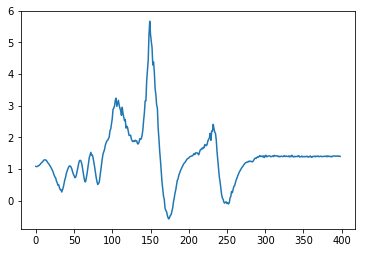

In [10]:
MA_wealth=np.array([])
for i in range(0,M-50,50):
    MA_wealth=np.append(MA_wealth,np.mean(terminal_wealth[i:i+50]))
plt.plot(MA_wealth)

In [11]:
perform=np.array([])
for i in range(1000):
    env.reset()
    x=initial
    t=0
    done= False
    while not done:
        state=torch.FloatTensor([[x-w]])
        s=torch.FloatTensor([[t]])
        action=actor.forward(s,state)
        action=action.detach().numpy()[0,0]
        action+=epsilon*np.random.normal()
        next_x,next_t,done=env.step(action)
        x=next_x
        t=next_t
    perform=np.append(perform,x)
avg_return=np.mean(perform)
variance=np.std(perform)**2
sharp=(np.mean(perform)-1)/np.std(perform)
print('Annualized Return:{}, Variance:{}, Sharp Ratio:{}'.format(avg_return,variance,sharp))

Annualized Return:1.3992201568765459, Variance:0.00445485418450852, Sharp Ratio:5.981301772796999
